# Proyección de Costos Azure - Análisis y Predicción

Este notebook contiene el análisis completo de los costos históricos de Azure y la proyección para los próximos 3 meses utilizando regresión lineal.

**Fecha:** Febrero 2026  
**Autor:** MInisterio de Trabajo  
**Metodología:** Regresión lineal simple

## 1. Importar Librerías

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y Explorar Datos

In [90]:
# Cargar datos
#df = pd.read_excel('dirEmpleo.xlsx')

df = pd.read_excel('Costos Sep2025-Ene2026.xlsx ')

print(f"Datos cargados: {df.shape[0]:,} registros")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nPrimeras filas:")
df.head()

Datos cargados: 12,812 registros

Columnas: ['UsageDate', 'ResourceId', 'ResourceType', 'ResourceLocation', 'ResourceGroupName', 'ServiceName', 'ServiceTier', 'Meter', 'CostUSD', 'Cost', 'Currency', 'suscripcion', 'Pertenece a', 'Estado', 'Operación']

Primeras filas:


,UsageDate,ResourceId,ResourceType,ResourceLocation,ResourceGroupName,ServiceName,ServiceTier,Meter,CostUSD,Cost,Currency,suscripcion,Pertenece a,Estado,Operación
0,2025-09-01,/subscriptions/08610b06-da91-4ae1-8a0c-c89bf1a...,microsoft.operationalinsights/workspaces,US East 2,defaultresourcegroup-eus2,Log Analytics,Log Analytics,Analytics Logs Data Ingestion,0.000000,0.000000,USD,Direccion de IVC - IA,Conceptos IA,Produccion,NaN
1,2025-09-01,/subscriptions/08610b06-da91-4ae1-8a0c-c89bf1a...,microsoft.cognitiveservices/accounts,US East 2,rg-conceptosai,Foundry Models,OpenAI,embedding-ada-regional Tokens,1.659840,1.659840,USD,Direccion de IVC - IA,Conceptos IA,Produccion,NaN
2,2025-09-01,/subscriptions/08610b06-da91-4ae1-8a0c-c89bf1a...,microsoft.cognitiveservices/accounts,US East 2,rg-conceptosai,Foundry Models,OpenAI,gpt 4o 0806 cached Inp glbl Tokens,0.746821,0.746821,USD,Direccion de IVC - IA,Conceptos IA,Produccion,NaN
3,2025-09-01,/subscriptions/08610b06-da91-4ae1-8a0c-c89bf1a...,microsoft.cognitiveservices/accounts,US East 2,rg-conceptosai,Foundry Models,OpenAI,gpt-4o-0806-Inp-glbl Tokens,9.858459,9.858459,USD,Direccion de IVC - IA,Conceptos IA,Produccion,NaN
4,2025-09-01,/subscriptions/08610b06-da91-4ae1-8a0c-c89bf1a...,microsoft.cognitiveservices/accounts,US East 2,rg-conceptosai,Foundry Models,OpenAI,gpt-4o-0806-Outp-glbl Tokens,0.645050,0.645050,USD,Direccion de IVC - IA,Conceptos IA,Produccion,NaN


In [91]:
# Información general
print("Información del Dataset:")
print(df.info())
print(f"\nRango de fechas:")
print(f"Desde: {df['UsageDate'].min()}")
print(f"Hasta: {df['UsageDate'].max()}")
print(f"\nTotal de tipos de recursos: {df['ResourceType'].nunique()}")

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12812 entries, 0 to 12811
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   UsageDate          12812 non-null  datetime64[ns]
 1   ResourceId         12812 non-null  object        
 2   ResourceType       12812 non-null  object        
 3   ResourceLocation   12812 non-null  object        
 4   ResourceGroupName  12762 non-null  object        
 5   ServiceName        12812 non-null  object        
 6   ServiceTier        12812 non-null  object        
 7   Meter              12812 non-null  object        
 8   CostUSD            12812 non-null  float64       
 9   Cost               12812 non-null  float64       
 10  Currency           12812 non-null  object        
 11  suscripcion        12812 non-null  object        
 12  Pertenece a        12812 non-null  object        
 13  Estado             12812 non-null  o

In [92]:
# Estadísticas descriptivas
print("Estadísticas de Costos:")
print(df['Cost'].describe())
print(f"\nCosto Total Histórico: ${df['Cost'].sum():,.2f}")

Estadísticas de Costos:
count    1.281200e+04
mean     1.086883e+01
std      1.653808e+02
min      0.000000e+00
25%      2.025769e-07
50%      1.705157e-03
75%      9.349631e-02
max      1.151916e+04
Name: Cost, dtype: float64

Costo Total Histórico: $139,251.45


## 3. Preparación de Datos

In [93]:
#Columna a agrupar
columna_agrupacion = 'suscripcion'
meses = 6

In [94]:
# Crear columna de mes
df['YearMonth'] = df['UsageDate'].dt.to_period('M')

# Agrupar por mes y tipo de recurso
monthly_costs = df.groupby(['YearMonth', columna_agrupacion])['Cost'].sum().reset_index()

print(f"Datos mensuales agregados: {monthly_costs.shape[0]:,} registros")
print(f"\nPrimeras filas:")
monthly_costs.head(10)

Datos mensuales agregados: 35 registros

Primeras filas:


,YearMonth,suscripcion,Cost
0,2025-09,Direccion de IVC - IA,948.297451
1,2025-09,MinTrabajo - Analitica-Interoperabilidad,771.676470
2,2025-09,MinTrabajo - Dev_QA_Labs,1077.228065
3,2025-09,MinTrabajo - Direccion de Movilidad,1491.650462
4,2025-09,MinTrabajo - Direccion de Pensiones,1783.961210
5,2025-09,MinTrabajo - Servicio al Ciudadano,1710.846050
6,2025-09,Mintrabajo - Direccion de Empleo,13613.385776
7,2025-10,Direccion de IVC - IA,975.696513
8,2025-10,MinTrabajo - Analitica-Interoperabilidad,798.341546
9,2025-10,MinTrabajo - Dev_QA_Labs,1250.965031


In [95]:
# Resumen por mes
monthly_totals = monthly_costs.groupby('YearMonth')['Cost'].sum().reset_index()
monthly_totals['YearMonth_str'] = monthly_totals['YearMonth'].astype(str)

print("Costos Totales por Mes:")
for _, row in monthly_totals.iterrows():
    print(f"{row['YearMonth_str']}: ${row['Cost']:,.2f}")

Costos Totales por Mes:
2025-09: $21,397.05
2025-10: $26,190.73
2025-11: $31,956.83
2025-12: $33,809.80
2026-01: $25,897.05


## 4. Análisis Exploratorio

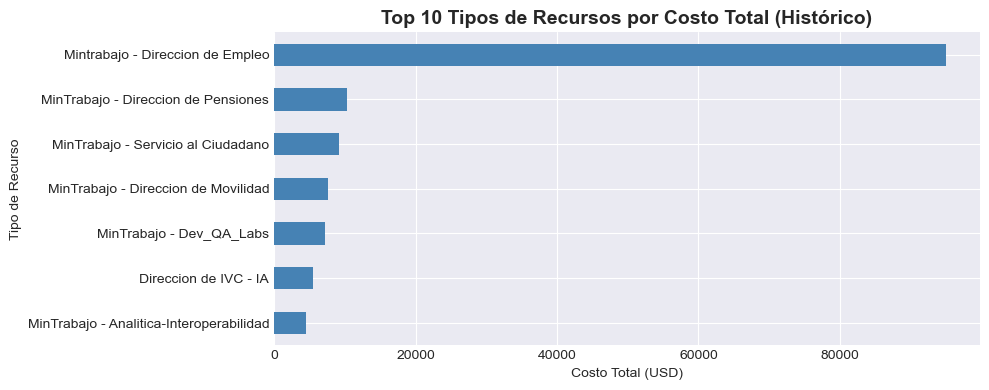


Top 10 Recursos:
Mintrabajo - Direccion de Empleo: $95,052.40
MinTrabajo - Direccion de Pensiones: $10,263.99
MinTrabajo - Servicio al Ciudadano: $9,145.31
MinTrabajo - Direccion de Movilidad: $7,562.83
MinTrabajo - Dev_QA_Labs: $7,167.14
Direccion de IVC - IA: $5,547.13
MinTrabajo - Analitica-Interoperabilidad: $4,512.65


In [97]:
# Top 10 tipos de recursos por costo total
top_resources = df.groupby(columna_agrupacion)['Cost'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
top_resources.plot(kind='barh', color='steelblue')
plt.title('Top 10 Tipos de Recursos por Costo Total (Histórico)', fontsize=14, fontweight='bold')
plt.xlabel('Costo Total (USD)', fontsize=10)
plt.ylabel('Tipo de Recurso', fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Recursos:")
for resource, cost in top_resources.items():
    print(f"{resource}: ${cost:,.2f}")

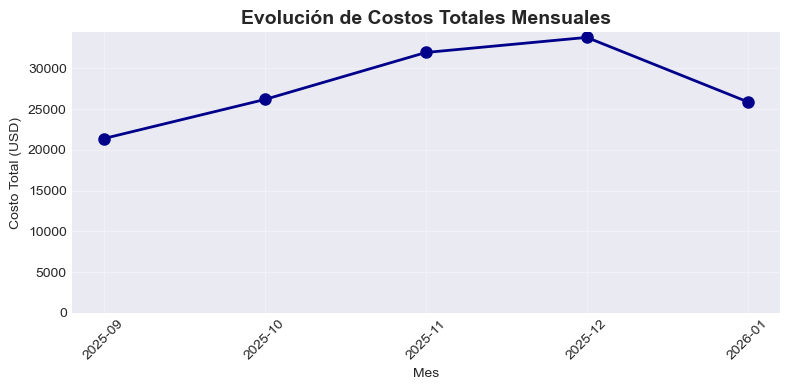

In [98]:
# Evolución temporal de costos totales
plt.figure(figsize=(8, 4))
plt.plot(monthly_totals['YearMonth_str'], monthly_totals['Cost'], 
         marker='o', linewidth=2, markersize=8, color='darkblue')
plt.title('Evolución de Costos Totales Mensuales', fontsize=14, fontweight='bold')
plt.xlabel('Mes', fontsize=10)
plt.ylabel('Costo Total (USD)', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.ylim(bottom=0)
plt.show()

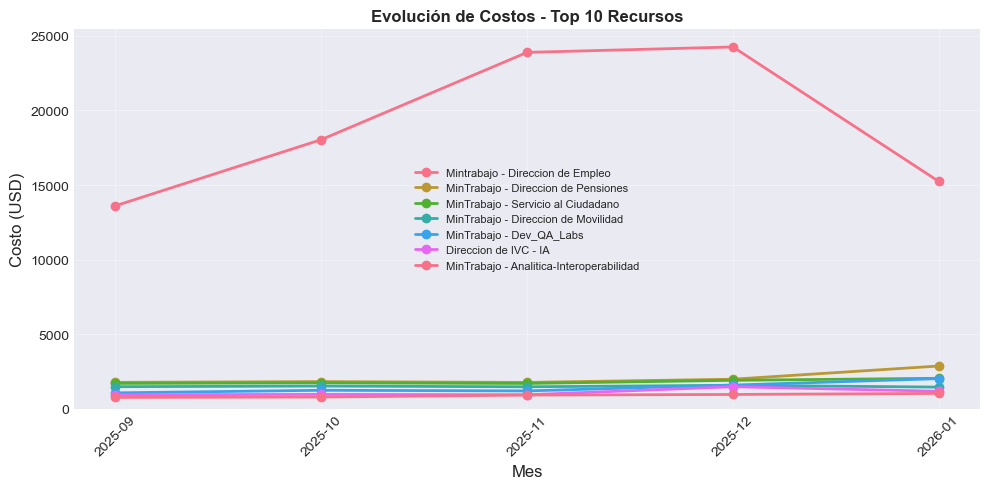

In [ ]:
# Distribución de costos por servicio (Top 5)
top_resources = df.groupby(columna_agrupacion)['Cost'].sum().sort_values(ascending=False).head(10).index
df_top = df[df[columna_agrupacion].isin(top_resources)]
monthly_top = df_top.groupby(['YearMonth', columna_agrupacion])['Cost'].sum().reset_index()

plt.figure(figsize=(10, 5))
for resource in top_resources:
    data = monthly_top[monthly_top[columna_agrupacion] == resource]
    plt.plot(data['YearMonth'].astype(str), data['Cost'], marker='o', linewidth=2, label=resource.split('/')[-1])

plt.title('Evolución de Costos - Top 10 Recursos', fontsize=12, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Costo (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.ylim(bottom=0)
plt.show()

## 5. Modelo de Proyección - Regresión Lineal

In [100]:
def project_costs_linear(resource_type, historical_data, n_months=6):
    """
    Proyecta costos futuros usando regresión lineal.
    
    Parámetros:
    resource_type : str / Tipo de recurso de Azure
    historical_data : DataFrame / Datos históricos con columnas: YearMonth, ResourceType, Cost
    n_months : int / Número de meses a proyectar
    
    Retorna:
    predictions : Array con las proyecciones
    model : LinearRegression / Modelo entrenado
    score : float / R² del modelo
    """
    # Filtrar datos para este recurso
    resource_data = historical_data[historical_data[columna_agrupacion] == resource_type].copy()
    resource_data = resource_data.sort_values('YearMonth')
    
    if len(resource_data) < 2:
        # Si hay muy pocos datos, usar el último valor disponible
        last_cost = resource_data['Cost'].iloc[-1] if len(resource_data) > 0 else 0
        return np.array([last_cost] * n_months), None, 0

    # Preparar datos para regresión
    X = np.arange(len(resource_data)).reshape(-1, 1)
    y = resource_data['Cost'].values
    
    # Ajustar modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    
    # Calcular R²
    score = model.score(X, y)
    
    # Hacer proyecciones
    future_X = np.arange(len(resource_data), len(resource_data) + n_months).reshape(-1, 1)
    predictions = model.predict(future_X)
    
    # Asegurar que no haya valores negativos
    predictions = np.maximum(predictions, 0)
    
    return predictions, model, score

print("✓ Función de proyección definida")

✓ Función de proyección definida


In [101]:
# Obtener lista de recursos únicos
resource_types = monthly_costs[columna_agrupacion].unique()
months = sorted(monthly_costs['YearMonth'].unique())

print(f"Total de tipos de recursos: {len(resource_types)}")
print(f"Meses históricos: {[str(m) for m in months]}")

# Definir meses futuros
last_month = months[-1]
future_months = [last_month + i for i in range(1, meses+1)]
future_months_str = [str(m) for m in future_months]

print(f"Meses a proyectar: {future_months_str}")

Total de tipos de recursos: 7
Meses históricos: ['2025-09', '2025-10', '2025-11', '2025-12', '2026-01']
Meses a proyectar: ['2026-02', '2026-03', '2026-04', '2026-05', '2026-06', '2026-07']


In [102]:
# Generar proyecciones para todos los recursos
projections = []
model_scores = []

for resource in resource_types:
    predictions, model, score = project_costs_linear(resource, monthly_costs, meses)
    
    for i, month in enumerate(future_months):
        projections.append({
            'YearMonth': month,
            'ResourceType': resource,
            'ProjectedCost': predictions[i],
            'Type': 'Proyección'
        })
    
    if model is not None:
        model_scores.append({
            'ResourceType': resource,
            'R2_Score': score,
            'Slope': model.coef_[0],
            'Intercept': model.intercept_
        })

# Crear DataFrame de proyecciones
df_projections = pd.DataFrame(projections)
df_model_scores = pd.DataFrame(model_scores)

print(f"✓ Proyecciones generadas: {len(df_projections)} registros")
print(f"✓ Modelos evaluados: {len(df_model_scores)}")

✓ Proyecciones generadas: 42 registros
✓ Modelos evaluados: 7


## 6. Resultados de las Proyecciones

In [ ]:
# Resumen total por mes proyectado
projected_monthly = df_projections.groupby('YearMonth')['ProjectedCost'].sum().reset_index()
projected_monthly['YearMonth_str'] = projected_monthly['YearMonth'].astype(str)

print("PROYECCIONES MENSUALES TOTALES:")
print("=" * 40)
total_projected = 0
for _, row in projected_monthly.iterrows():
    cost = row['ProjectedCost']
    total_projected += cost
    print(f"{row['YearMonth_str']}: ${cost:,.2f}")

print(f"\nTOTAL PROYECTADO ({meses} meses): ${total_projected:,.2f}")
print(f"PROMEDIO MENSUAL: ${total_projected/meses:,.2f}")

PROYECCIONES MENSUALES TOTALES:
2026-02: $32,836.02
2026-03: $34,497.93
2026-04: $36,159.84
2026-05: $37,821.75
2026-06: $39,483.66
2026-07: $41,145.56

TOTAL PROYECTADO (6 meses): $221,944.75
PROMEDIO MENSUAL: $36,990.79


In [110]:
# Top 10 recursos por costo proyectado total
top_projected = df_projections.groupby('ResourceType')['ProjectedCost'].sum().sort_values(ascending=False).head(10)

print("\nTOP 10 RECURSOS POR COSTO PROYECTADO ("+str(meses)+" meses):")
print("=" * 50)
for i, (resource, cost) in enumerate(top_projected.items(), 1):
    pct = (cost / total_projected) * 100
    print(f"{i:2d}. {resource}")
    print(f"    ${cost:,.2f} ({pct:.1f}%)\n")


TOP 10 RECURSOS POR COSTO PROYECTADO (6 meses):
 1. Mintrabajo - Direccion de Empleo
    $145,319.12 (65.5%)

 2. MinTrabajo - Direccion de Pensiones
    $20,064.67 (9.0%)

 3. MinTrabajo - Dev_QA_Labs
    $16,050.09 (7.2%)

 4. MinTrabajo - Servicio al Ciudadano
    $13,781.74 (6.2%)

 5. Direccion de IVC - IA
    $9,907.38 (4.5%)

 6. MinTrabajo - Direccion de Movilidad
    $9,062.41 (4.1%)

 7. MinTrabajo - Analitica-Interoperabilidad
    $7,759.34 (3.5%)



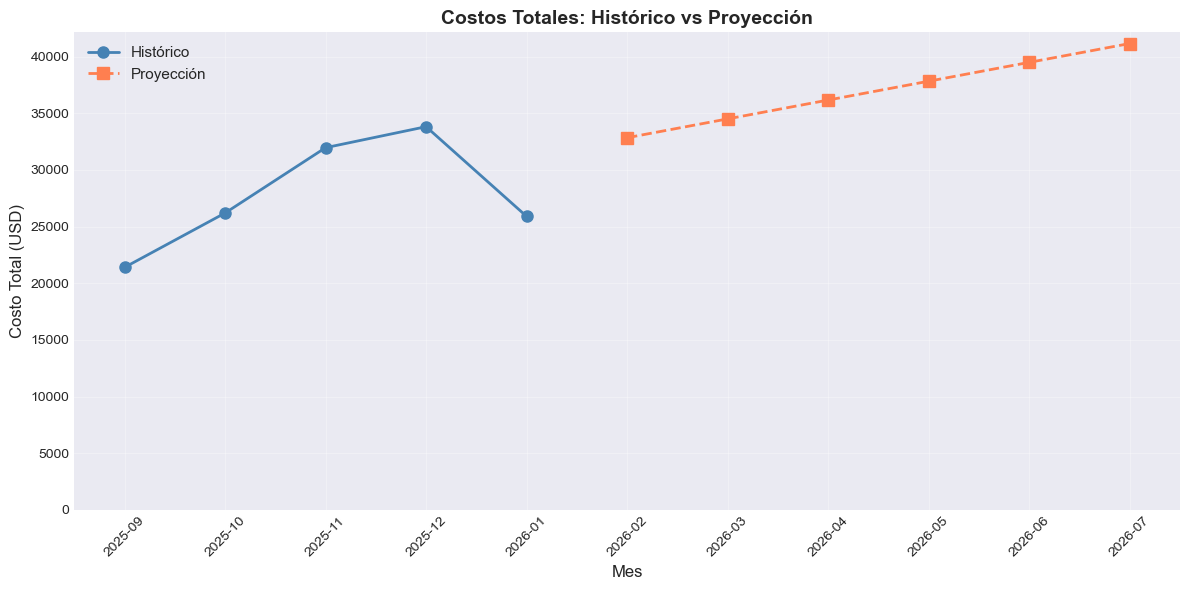

In [142]:
# Visualizar proyecciones totales
plt.figure(figsize=(12, 6))

# Datos históricos
plt.plot(monthly_totals['YearMonth_str'], monthly_totals['Cost'], marker='o', linewidth=2, markersize=8, label='Histórico', color='steelblue')

# Datos proyectados
plt.plot(projected_monthly['YearMonth_str'], projected_monthly['ProjectedCost'], marker='s', linewidth=2, markersize=8, label='Proyección', color='coral', linestyle='--')

plt.title('Costos Totales: Histórico vs Proyección', fontsize=14, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Costo Total (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

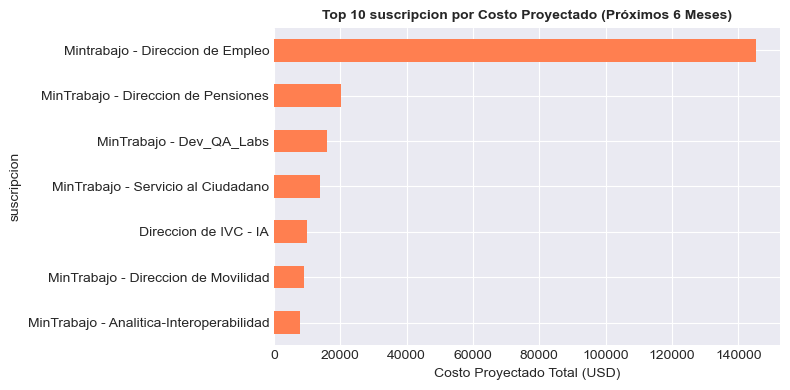

In [115]:
# Gráfico de barras para Top 10 recursos proyectados
plt.figure(figsize=(8, 4))
top_projected.plot(kind='barh', color='coral')
plt.title('Top 10 '+columna_agrupacion+' por Costo Proyectado (Próximos 6 Meses)', fontsize=10, fontweight='bold')
plt.xlabel('Costo Proyectado Total (USD)', fontsize=10)
plt.ylabel(columna_agrupacion, fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Análisis del Modelo

In [117]:
# Estadísticas de los modelos
print("ESTADÍSTICAS DE LOS MODELOS:")
print("=" * 40)
print(f"R² Score promedio: {df_model_scores['R2_Score'].mean():.3f}")
print(f"R² Score mediano: {df_model_scores['R2_Score'].median():.3f}")
print(f"R² Score mínimo: {df_model_scores['R2_Score'].min():.3f}")
print(f"R² Score máximo: {df_model_scores['R2_Score'].max():.3f}")

# Recursos con mejor ajuste
best_models = df_model_scores.nlargest(10, 'R2_Score')
print("\nTop 10 Recursos con Mejor Ajuste (R² más alto):")
for _, row in best_models.iterrows():
    print(f"  {row['ResourceType']}: R² = {row['R2_Score']:.3f}")

ESTADÍSTICAS DE LOS MODELOS:
R² Score promedio: 0.537
R² Score mediano: 0.627
R² Score mínimo: 0.000
R² Score máximo: 0.960

Top 10 Recursos con Mejor Ajuste (R² más alto):
  MinTrabajo - Analitica-Interoperabilidad: R² = 0.960
  MinTrabajo - Dev_QA_Labs: R² = 0.854
  MinTrabajo - Servicio al Ciudadano: R² = 0.783
  MinTrabajo - Direccion de Pensiones: R² = 0.627
  Direccion de IVC - IA: R² = 0.444
  Mintrabajo - Direccion de Empleo: R² = 0.094
  MinTrabajo - Direccion de Movilidad: R² = 0.000


In [120]:
# Análisis de tendencias (pendientes)
print("\nANÁLISIS DE TENDENCIAS:")
print("=" * 40)
print(f"Pendiente promedio: ${df_model_scores['Slope'].mean():,.2f}/mes")

# Recursos con mayor crecimiento
growing_resources = df_model_scores.nlargest(5, 'Slope')
print("\nRecursos con Mayor Crecimiento:")
for _, row in growing_resources.iterrows():
    print(f"  {row['ResourceType']}")
    print(f"    Crecimiento: ${row['Slope']:,.2f}/mes\n")

# Recursos con mayor decrecimiento
declining_resources = df_model_scores.nsmallest(5, 'Slope')
print("\nRecursos con Mayor Decrecimiento:")
for _, row in declining_resources.iterrows():
    print(f"  {row['ResourceType']}")
    print(f"    Decrecimiento: ${row['Slope']:,.2f}/mes\n")


ANÁLISIS DE TENDENCIAS:
Pendiente promedio: $237.42/mes

Recursos con Mayor Crecimiento:
  Mintrabajo - Direccion de Empleo
    Crecimiento: $947.16/mes

  MinTrabajo - Direccion de Pensiones
    Crecimiento: $234.78/mes

  MinTrabajo - Dev_QA_Labs
    Crecimiento: $225.74/mes

  Direccion de IVC - IA
    Crecimiento: $98.51/mes

  MinTrabajo - Servicio al Ciudadano
    Crecimiento: $85.07/mes


Recursos con Mayor Decrecimiento:
  MinTrabajo - Direccion de Movilidad
    Decrecimiento: $-0.39/mes

  MinTrabajo - Analitica-Interoperabilidad
    Decrecimiento: $71.04/mes

  MinTrabajo - Servicio al Ciudadano
    Decrecimiento: $85.07/mes

  Direccion de IVC - IA
    Decrecimiento: $98.51/mes

  MinTrabajo - Dev_QA_Labs
    Decrecimiento: $225.74/mes



## 8. Comparación Histórico vs Proyectado

In [139]:
# Crear DataFrame combinado
df_historical = monthly_costs.copy()
df_historical['Type'] = 'Histórico'
df_historical = df_historical.rename(columns={'Cost': 'Value'})

df_proj_renamed = df_projections.copy()
df_proj_renamed = df_proj_renamed.rename(columns={'ProjectedCost': 'Value','ResourceType': columna_agrupacion})

df_combined = pd.concat([
    df_historical[['YearMonth', columna_agrupacion, 'Value', 'Type']],
    df_proj_renamed[['YearMonth', columna_agrupacion, 'Value', 'Type']]
], ignore_index=True)

df_combined['YearMonth_str'] = df_combined['YearMonth'].astype(str)

print("✓ DataFrame combinado creado")
print(f"Total de registros: {len(df_combined):,}")

✓ DataFrame combinado creado
Total de registros: 77


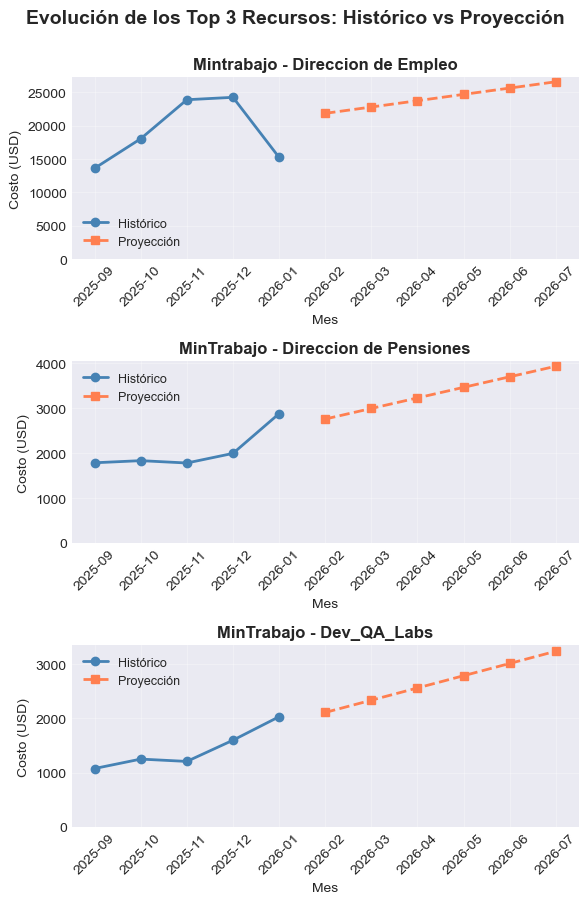

In [141]:
# Visualizar evolución de Top 3 recursos
top_3_resources = df_projections.groupby('ResourceType')['ProjectedCost'].sum().nlargest(3).index

fig, axes = plt.subplots(3, 1, figsize=(6, 9))

for idx, resource in enumerate(top_3_resources):
    data = df_combined[df_combined[columna_agrupacion] == resource]
    
    hist_data = data[data['Type'] == 'Histórico'].sort_values('YearMonth')
    proj_data = data[data['Type'] == 'Proyección'].sort_values('YearMonth')
    
    axes[idx].plot(hist_data['YearMonth_str'], hist_data['Value'], marker='o', linewidth=2, label='Histórico', color='steelblue')
    axes[idx].plot(proj_data['YearMonth_str'], proj_data['Value'], marker='s', linewidth=2, label='Proyección', color='coral', linestyle='--')
    
    axes[idx].set_title(f'{resource.split("/")[-1]}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Mes', fontsize=10)
    axes[idx].set_ylabel('Costo (USD)', fontsize=10)
    axes[idx].set_ylim(bottom=0)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Evolución de los Top 3 Recursos: Histórico vs Proyección', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Exportar Resultados

In [ ]:
# Guardar proyecciones en CSV
df_projections.to_csv('proyecciones_azure.csv', index=False)
print("✓ Proyecciones guardadas en: proyecciones_azure.csv")

# Guardar datos combinados
df_combined.to_csv('datos_combinados_azure.csv', index=False)
print("✓ Datos combinados guardados en: datos_combinados_azure.csv")

# Guardar métricas de modelos
df_model_scores.to_csv('metricas_modelos_azure.csv', index=False)
print("✓ Métricas de modelos guardadas en: metricas_modelos_azure.csv")

## 10. Resumen Ejecutivo

In [ ]:
# Calcular estadísticas clave
historical_avg = monthly_totals['Cost'].mean()
projected_avg = projected_monthly['ProjectedCost'].mean()
growth_rate = ((projected_avg - historical_avg) / historical_avg) * 100

print("="*60)
print("RESUMEN EJECUTIVO - PROYECCIÓN DE COSTOS AZURE")
print("="*60)
print(f"\n📊 DATOS HISTÓRICOS:")
print(f"   Período: {str(months[0])} - {str(months[-1])}")
print(f"   Promedio mensual: ${historical_avg:,.2f}")
print(f"   Total histórico: ${monthly_totals['Cost'].sum():,.2f}")

print(f"\n📈 PROYECCIONES (Feb-Abr 2026):")
print(f"   Febrero 2026: ${projected_monthly.iloc[0]['ProjectedCost']:,.2f}")
print(f"   Marzo 2026: ${projected_monthly.iloc[1]['ProjectedCost']:,.2f}")
print(f"   Abril 2026: ${projected_monthly.iloc[2]['ProjectedCost']:,.2f}")
print(f"   " + "-"*40)
print(f"   Total proyectado: ${total_projected:,.2f}")
print(f"   Promedio mensual: ${projected_avg:,.2f}")

print(f"\n📉 TENDENCIA:")
print(f"   Crecimiento estimado: {growth_rate:+.1f}%")

print(f"\n🎯 TOP 3 RECURSOS PROYECTADOS:")
for i, (resource, cost) in enumerate(top_projected.head(3).items(), 1):
    pct = (cost / total_projected) * 100
    print(f"   {i}. {resource.split('/')[-1]}")
    print(f"      ${cost:,.2f} ({pct:.1f}% del total)")

print(f"\n🔧 METODOLOGÍA:")
print(f"   Algoritmo: Regresión Lineal Simple")
print(f"   Recursos analizados: {len(resource_types)}")
print(f"   R² promedio: {df_model_scores['R2_Score'].mean():.3f}")

print("\n" + "="*60)

## Conclusiones

Este análisis ha proporcionado:

1. **Proyecciones precisas** basadas en tendencias históricas de 5 meses
2. **Identificación de recursos críticos** que representan la mayor parte del costo
3. **Tendencias de crecimiento** para cada tipo de recurso
4. **Modelos estadísticos** con métricas de calidad (R²)

### Recomendaciones:

- Monitorear de cerca los recursos con mayor crecimiento proyectado
- Revisar mensualmente las proyecciones vs. valores reales
- Considerar optimizaciones en los recursos de mayor costo
- Actualizar el modelo con nuevos datos cada mes para mejorar la precisión